# Binary classification with logistic regression

Over the last two tutorials we worked through how to implement a linear regression model,
both [*from scratch*](Linear-Regression-Scratch.ipynb)
and [using BigDL-Keras](Linear-Regression-With-BigDL-Keras.ipynb) to automate most of the repetitive work 
like allocating and initializing parameters, defining loss functions, and implementing optimizers.

Regression is the hammer we reach for when we want to answer *how much?* or *how many?* questions.
If you want to predict the number of dollars (the *price*) at which a house will be sold,
or the number of wins a baseball team might have, 
or the number of days that a patient will remain hospitalized before being discharged,
then you're probably looking for a regression model.

Based on our experience, in industry, we're more often interested in making categorical assignments.
*Does this email belong in the spam folder or the inbox*?
*How likely is this custromer to sign up for subscription service?*
When we're interested in either assigning datapoints to categories
or assessing the *probability* that a category applies,
we call this task *classification*. 

The simplest kind of classification problem is *binary classification*,
when there are only two categories,
so let's start there. 
Let's call our two categories the positive class $y_i=1$ and the negative class $y_i = 0$.
Even with just two categories, and even confining ourselves to linear models, 
there are many ways we might approach the problem. 
For example, we might try to draw a line that best separates the points.

![](../img/linear-separator.png)

A whole family of algorithms called support vector machines pursue this approach.
The main idea here is choose a line that maximizes the margin to the closest data points on either side of the decision boundary. 
In these approaches, only the points closest to the decision boundary (the support vectors) 
actually influence the choice of the linear separator.

With neural networks, we usually approach the problem differently. 
Instead of just trying to separate the points,
we train a probabilistic classifier which estimates,
for each data point, the conditional probability that it belongs to the positive class. 

Recall that in linear regression, we made predictions of the form

$$ \hat{y} = \boldsymbol{w}^T \boldsymbol{x} + b. $$

We are interested in asking the question *"what is the probability that example $x$ belongs to the positive class?"*
A regular linear model is a poor choice here because it can output values greater than $1$ or less than $0$.
To coerce reasonable answers from our model, 
we're going to modify it slightly,
by running the linear function through a sigmoid activation function $\sigma$:

$$ \hat{y} =\sigma(\boldsymbol{w}^T \boldsymbol{x} + b). $$

The sigmoid function $\sigma$, sometimes called a squashing function or a *logistic* function - thus the name logistic regression - maps a real-valued input to the range 0 to 1.
Specifically, it has the functional form:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Let's get our imports out of the way and visualize the logistic function using `BigDL` and `matplotlib`.

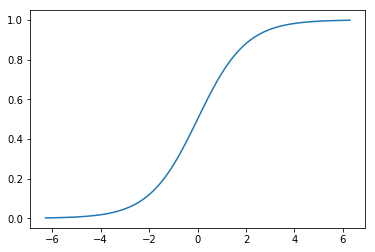

In [19]:
import numpy as np 
import matplotlib.pyplot as plt

def logistic(z):
    return 1. / (1. + np.exp(-z))
    
x = np.linspace(-2*np.pi, 2*np.pi, 100)    
y = logistic(x)

plt.plot(x,y)
plt.show()

Because the sigmoid outputs a value between $0$ and $1$,
it's more reasonable to think of it as a probability.
Note that an input of $0$ gives a value of $.5$. 
So in the common case, where we want to predict positive whenever the probability is greater than $.5$
and negative whenever the probability is less than $.5$,
we can just look at the sign of $\boldsymbol{w}^T \boldsymbol{x} + b$.

## Binary cross-entropy loss

Now that we've got a model that outputs probabilities,
we need to choose a loss function.
When we wanted to predict *how much* we used squared error $y-\hat{y}^2$,
as our measure our model's performance. 

Since now we're thinking about outputing probabilities,
one natural objective is to say that we should choose the weights 
that give the actual labels in the training data the highest probability.

$$\max_{\theta} P_{\theta}( (y_1, ..., y_n) | \boldsymbol{x}_1,...,\boldsymbol{x}_n )$$

Because each example is independent of the others, and each label depends only on the features of the corresponding examples, we can rewrite the above as

$$\max_{\theta} P_{\theta}(y_1|\boldsymbol{x}_1)P_{\theta}(y_2|\boldsymbol{x}_2) ... P(y_n|\boldsymbol{x}_n)$$



This function is a product over the examples, but in general, because we want to train by stochastic gradient descent, it's a lot easier to work with a loss function that breaks down as a sum over the training examples. 

$$ \max_{\theta} \log P_{\theta}(y_1|\boldsymbol{x}_1) + ... + \log P(y_n|\boldsymbol{x}_n)$$

Because we typically express our objective as a *loss* we can just flip the sign, giving us the *negative log probability:*

$$  \min_{\theta} \left(- \sum_{i=1}^n \log P_{\theta}(y_i|\boldsymbol{x}_i)\right)$$

If we interpret $\hat{y_i}$ as the probability that the $i$-th example belongs to the positive class (i.e $y_i=1$),
then $1 - \hat{y_i}$ is the probability that the $i$-th example belongs to the negative class (i.e $y_i=0$). This is equivalent to saying

$$ P_{\theta}(y_i|\boldsymbol{x}_i) = \begin{cases}
    \hat{y}_i, & \text{if } y_i = 1\\
    1-\hat{y}_i, & \text{if } y_i = 0
\end{cases} $$

which can be written in a more compact form

$$ P_{\theta}(y_i|\boldsymbol{x}_i) = \hat{y}_i^{y_i}(1-\hat{y}_i)^{1-y_i} $$

Thus we can express our learning objective as:

$$ \ell (\boldsymbol{y}, \boldsymbol{\hat{y}}) =  - \sum_{i=1}^n y_i \log \hat{y}_i + (1-y_i) \log (1-\hat{y}_i).$$


If you're learning machine learning for the first time, that might have been too much information too quickly. 
Let's take a look at this loss function and break down what's going on more slowly. 
The loss function consists of two terms, $y_i \log \hat{y}_i$ and $(1-y_i) \log (1-\hat{y}_i)$.
Because $y_i$ only takes values $0$ or $1$, for a given data point, one of these terms disappears. 
When $y_i$ is $1$, this loss says that we should maximize $\log \hat{y}_i$, giving higher probability to the *correct* answer. 
When $y_i$ is $0$, this loss function takes value $\log (1-\hat{y}_i)$. That says that we should maximize the value $1-\hat{y}$ which we already know is the probability assigned to $\boldsymbol{x}_i$ belonging to the negative class.


Note that this loss function is commonly called *log loss* and is also commonly referred to as *binary cross entropy*. It is a special case of negative log likelihood. And it is a special case of cross-entropy, which can apply to the multi-class ($>2$) setting.

 
While for linear regression, we demonstrated a completely different implementation *from scratch* and *with `gluon`*, here we're going to demonstrate how we can mix and match the two.  We'll use `gluon` for our modeling, but we'll write our loss function from scratch.

## Data

As usual, we'll want to work out these concepts using a real dataset. This time around, we'll use the *Adult* dataset taken from the [UCI repository](http://archive.ics.uci.edu/ml/datasets/). 
The dataset was constructed by Barry Becker from 1994 census data.
In its original form, the dataset contained $14$ features, including age, education, occupation, sex, native-country, among others. 
In this version, [hosted by National Taiwan University](https://www.csie.ntu.edu.tw/%7Ecjlin/libsvmtools/datasets/binary.html),
the data have been re-processed to $123$ binary features each representing quantiles among the original features.
The label is a binary indicator indicating whether the person corresponding to each row made more ($y_i = 1$) or less ($y_i = 0$) than $50,000 of income in 1994.
The dataset we're working with contains 30,956 training examples and 1,605 examples set aside for testing.
We can read the datasets into main memory like so: